# Bike-Sharing Dataset

The [Bike-Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. The dataset contains 14 features with information about the day-type, e.g., month, hour, which day of the week, whether it is working-day, and the weather conditions, e.g., temperature, humidity, wind speed, etc. The target variable is the number of bike rentals per hour. The dataset contains 17,379 instances. 

In [1]:
import effector
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/eff-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess the data

In [2]:
from ucimlrepo import fetch_ucirepo 

bike_sharing_dataset = fetch_ucirepo(id=275) 
X = bike_sharing_dataset.data.features 
y = bike_sharing_dataset.data.targets 

In [3]:
X = X.drop(["dteday", "atemp"], axis=1)

In [4]:
X.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0


In [5]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for col_name in X.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
for col_name in y.columns:
    print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(y[col_name].unique()), y[col_name].mean(), y[col_name].std(), y[col_name].min(), y[col_name].max()))

Design matrix shape: (17379, 11)
---------------------------------
Feature: season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
Feature: yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
Feature: mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
Feature: hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
Feature: holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
Feature: weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
Feature: workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
Feature: weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
Feature: temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
Feature: hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
Feature: wind

In [6]:
def preprocess(X, y):
    # Standarize X
    X_df = X
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = y
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [7]:
def split(X_df, Y_df):
    # shuffle indices
    indices = X_df.index.tolist()
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)


## Fit a Neural Network

In [8]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6231 - mae: 0.5745 - root_mean_squared_error: 0.7853
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3871 - mae: 0.4508 - root_mean_squared_error: 0.6220
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2985 - mae: 0.3857 - root_mean_squared_error: 0.5462
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2252 - mae: 0.3337 - root_mean_squared_error: 0.4744
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1643 - mae: 0.2857 - root_mean_squared_error: 0.4052
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1189 - mae: 0.2379 - root_mean_squared_error: 0.3446
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0899 - mae: 0.2070 - root_mean_squared_error: 0.2997
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0741 - mae: 0.1879 - root_mean_squared_error: 0.2722
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0655 - mae: 0.1765 - root_m

[0.0765402615070343, 0.2062656432390213, 0.2766591012477875]

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a root mean squared error on the test of about $0.24$ units, that corresponds to approximately \(0.26 * 181 = 47\) counts.

## Explain

We will focus on the feature `temp` (temperature) because its global effect is quite heterogeneous and the heterogeneity can be further explained using regional effects.

In [9]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()

In [10]:
scale_y = {"mean": y_mean.iloc[0], "std": y_std.iloc[0]}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]
scale_x = scale_x_list[3]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"
y_limits=[-200, 800]
dy_limits = [-300, 300]

In [11]:
scale_x_list[8]["mean"] += 8
scale_x_list[8]["std"] *= 47

scale_x_list[9]["std"] *= 100
scale_x_list[10]["std"] *= 67

## Global Effect  

**Overview of All Features**

We start by examining all relevant features. Feature effect methods are generally more meaningful for numerical features. To compare effects across features more easily, we standardize the `y_limits`.  

Relevant features:

- `month`  
- `hr`  
- `weekday`  
- `workingday`  
- `temp`  
- `humidity`  
- `windspeed` 

We observe that features: `hour`, `temperature` and `humidity` have an intersting structure. Out of them `hour` has by far the most influence on the output, so it makes sensce to fucse on it further.

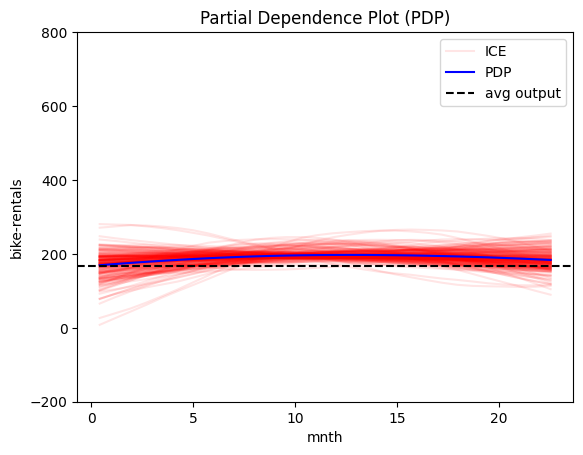

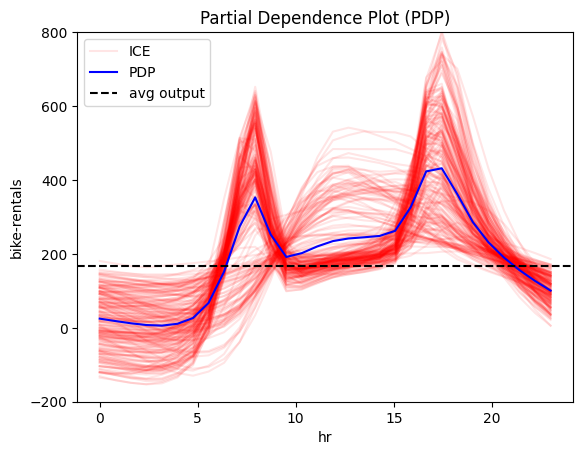

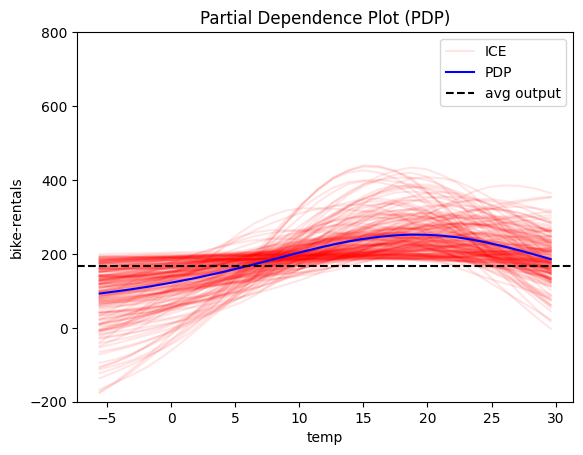

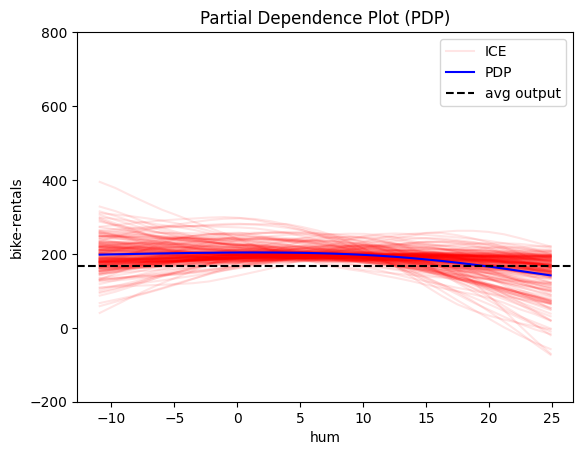

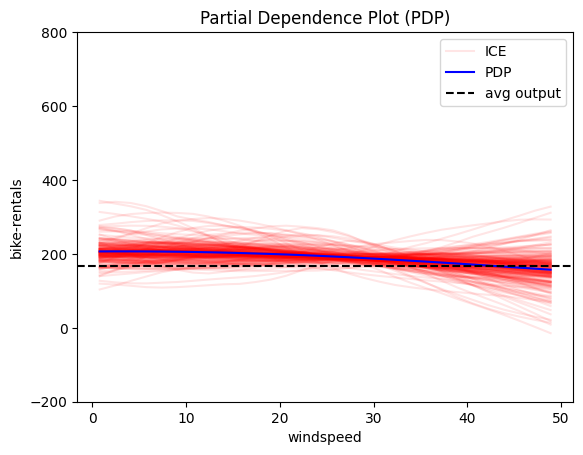

In [12]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=2000)
for i in [2, 3, 8, 9, 10]:
    pdp.plot(feature=i, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True, nof_ice=200, y_limits=y_limits)

### PDP 

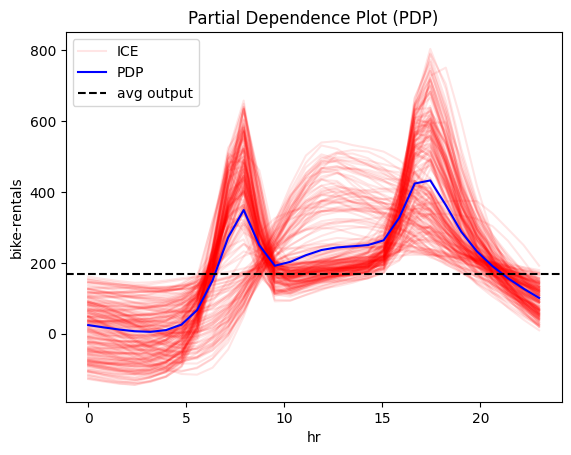

In [13]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=5000)
pdp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True, nof_ice=200)

### RHALE

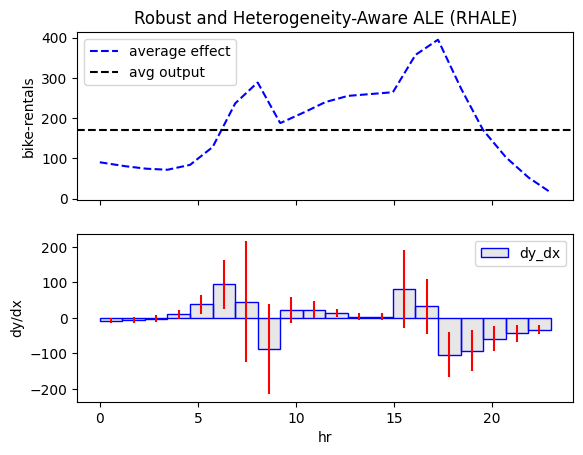

In [14]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
rhale.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

PermutationExplainer explainer: 501it [02:55,  2.76it/s]                         


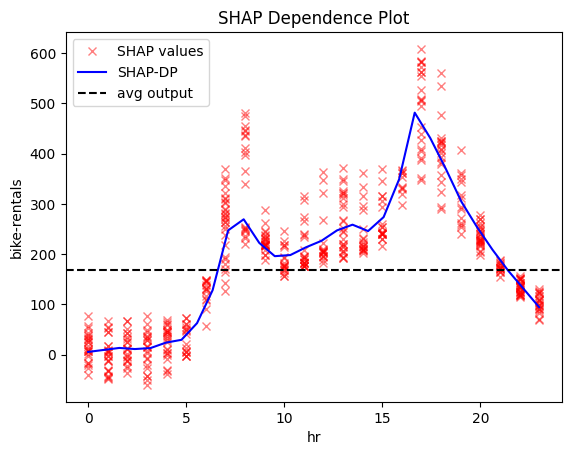

In [15]:
shap_dp = effector.ShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=500)
shap_dp.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### Conclusion  

All methods agree that `hour` affects `bike-rentals` with two peaks, around 8:00 and 17:00, likely reflecting commute hours. However, the effect varies significantly, so regional effects may help in understanding the origin of this heterogeneity.

## Regional Effect

### RegionalPDP

In [16]:
regional_pdp = effector.RegionalPDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=5_000)
regional_pdp.summary(features=3, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:02<00:00,  2.72s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.24 | inst: 5000 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.12 | inst: 1584 | w: 0.32]
        temp ≤ 6.81 🔹 [id: 2 | heter: 0.06 | inst: 768 | w: 0.15]
        temp > 6.81 🔹 [id: 3 | heter: 0.08 | inst: 816 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 4 | heter: 0.12 | inst: 3416 | w: 0.68]
        temp ≤ 6.81 🔹 [id: 5 | heter: 0.08 | inst: 1511 | w: 0.30]
        temp > 6.81 🔹 [id: 6 | heter: 0.09 | inst: 1905 | w: 0.38]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.24
    Level 1🔹heter: 0.12 | 🔻0.12 (48.49%)
        Level 2🔹heter: 0.08 | 🔻0.04 (34.41%)




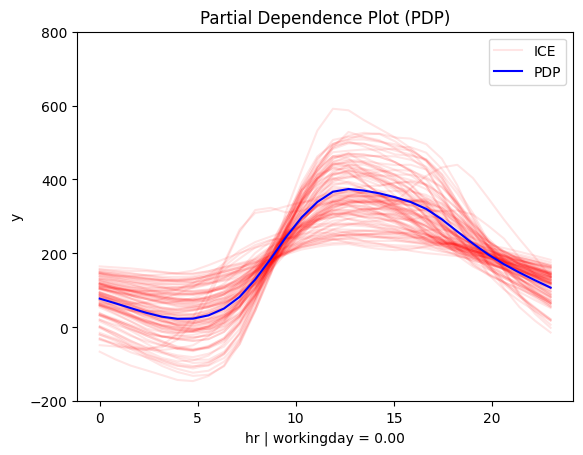

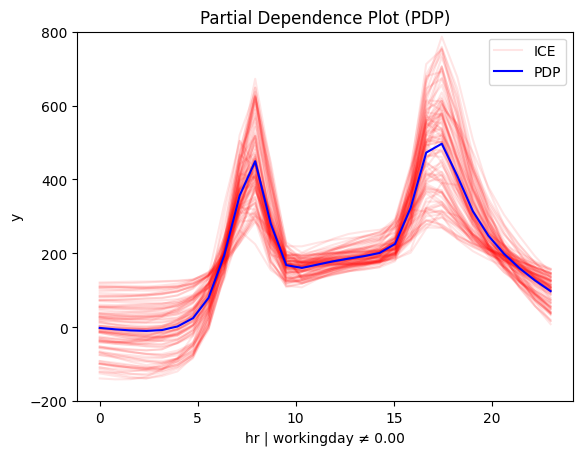

In [17]:
for node_idx in [1, 4]:
    regional_pdp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

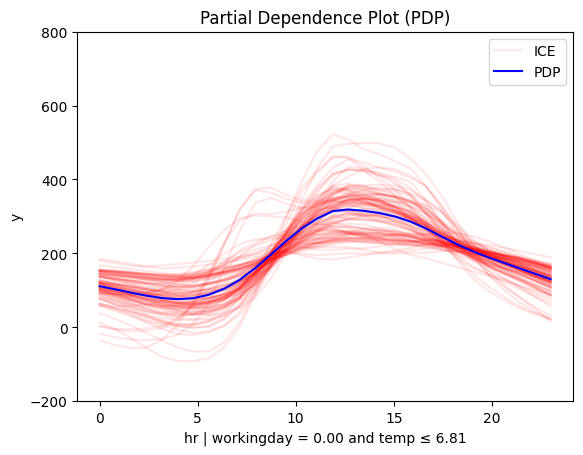

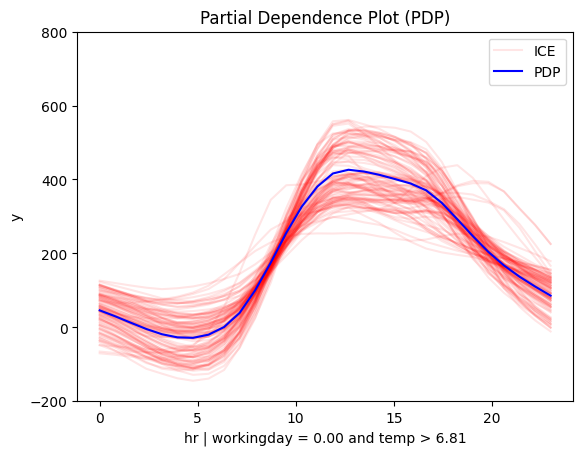

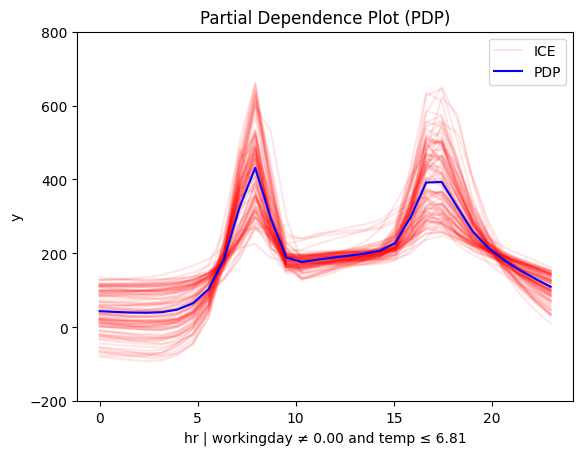

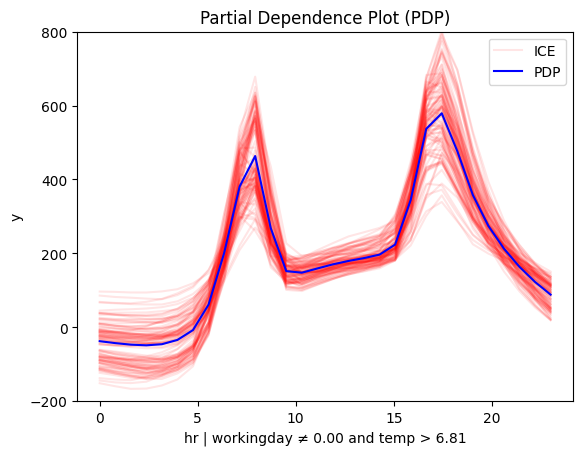

In [18]:
for node_idx in [2, 3, 5, 6]:
    regional_pdp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### RegionalRHALE

In [19]:
regional_rhale = effector.RegionalRHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
regional_rhale.summary(features=3, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:02<00:00,  2.33s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 6.25 | inst: 13903 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.65 | inst: 4385 | w: 0.32]
        temp ≤ 6.81 🔹 [id: 2 | heter: 0.36 | inst: 2187 | w: 0.16]
        temp > 6.81 🔹 [id: 3 | heter: 0.52 | inst: 2198 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 4 | heter: 6.49 | inst: 9518 | w: 0.68]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 6.25
    Level 1🔹heter: 4.65 | 🔻1.60 (25.63%)
        Level 2🔹heter: 0.14 | 🔻4.51 (97.00%)




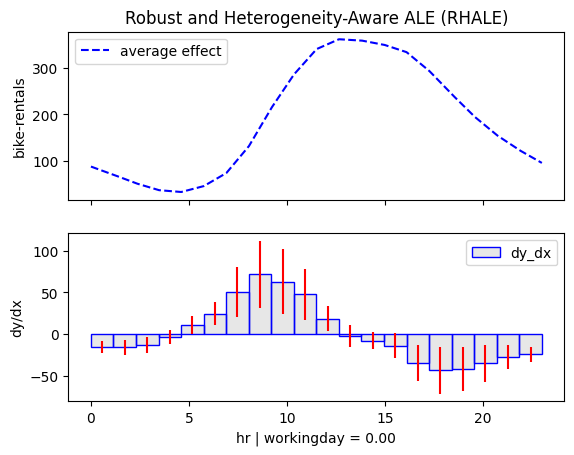

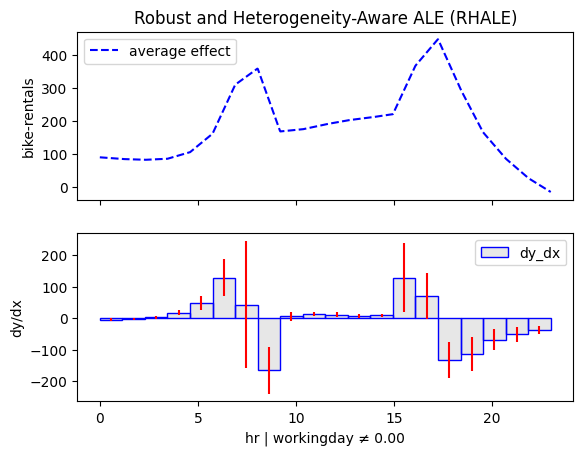

In [20]:
regional_rhale.plot(feature=3, node_idx=1, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)
regional_rhale.plot(feature=3, node_idx=4, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

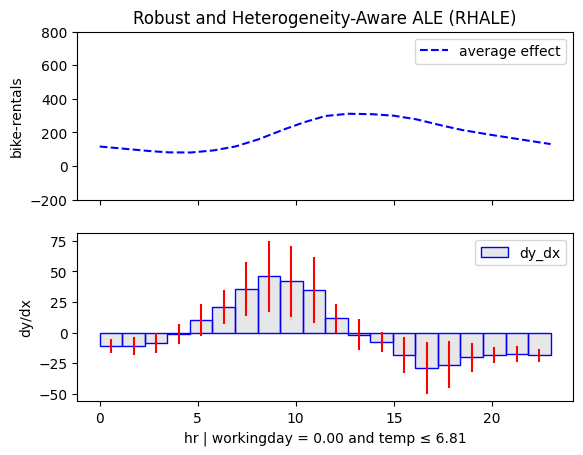

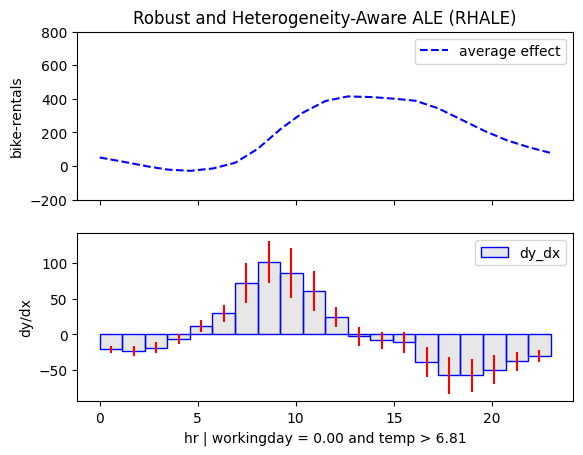

In [25]:
for node_idx in [2, 3]:
    regional_rhale.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### Regional SHAP-DP

In [21]:
regional_shap_dp = effector.RegionalShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=500)

In [22]:
regional_shap_dp.summary(features=3, scale_x_list=scale_x_list)

PermutationExplainer explainer: 501it [02:59,  2.63it/s]
100%|██████████| 1/1 [03:00<00:00, 180.39s/it]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.05 | inst: 500 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.02 | inst: 150 | w: 0.30]
        temp ≤ 6.81 🔹 [id: 2 | heter: 0.01 | inst: 71 | w: 0.14]
        temp > 6.81 🔹 [id: 3 | heter: 0.01 | inst: 79 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 4 | heter: 0.03 | inst: 350 | w: 0.70]
        temp ≤ 2.20 🔹 [id: 5 | heter: 0.01 | inst: 121 | w: 0.24]
        temp > 2.20 🔹 [id: 6 | heter: 0.02 | inst: 229 | w: 0.46]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.05
    Level 1🔹heter: 0.03 | 🔻0.02 (43.97%)
        Level 2🔹heter: 0.02 | 🔻0.01 (39.22%)




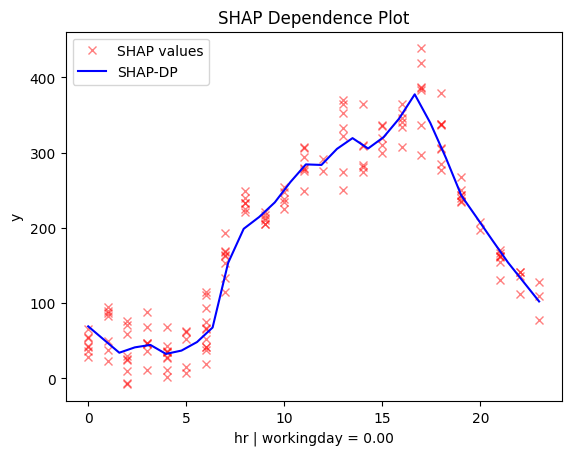

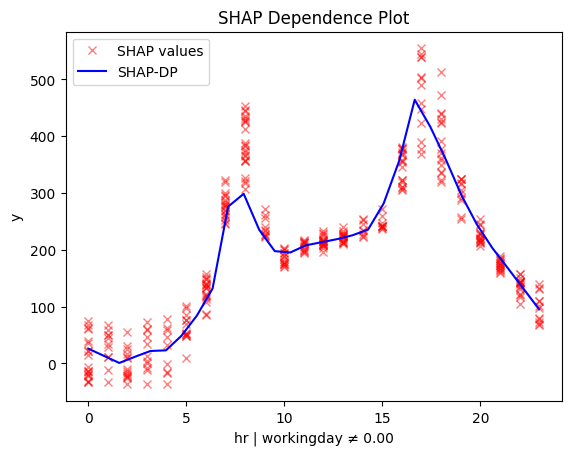

In [23]:
for node_idx in [1, 4]:
    regional_shap_dp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

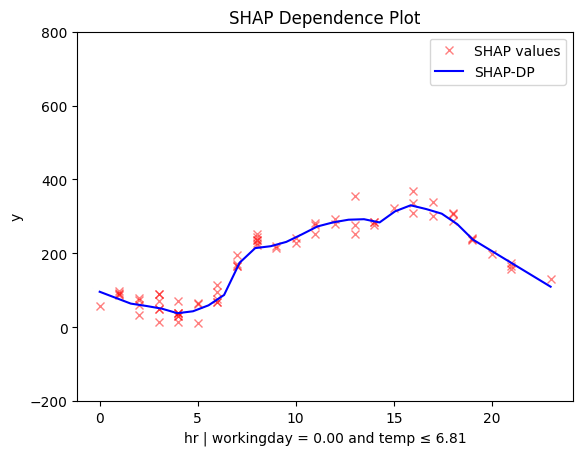

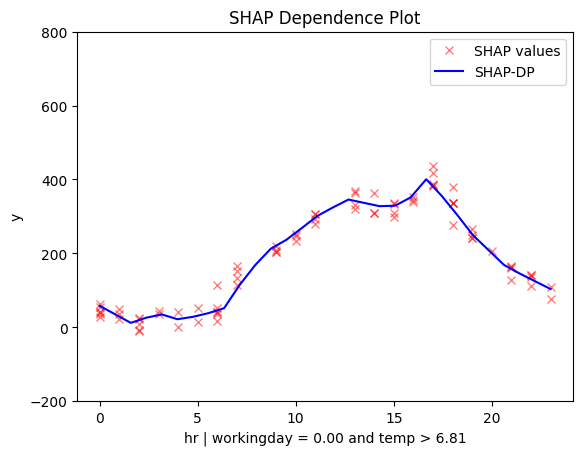

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/effector-git/effector/effector/global_effect_shap.py:469: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.feature_effect["feature_" + str(feature)]["spline_std"](x))


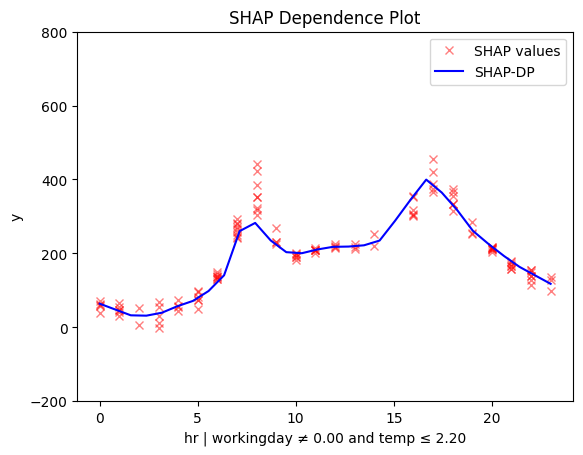

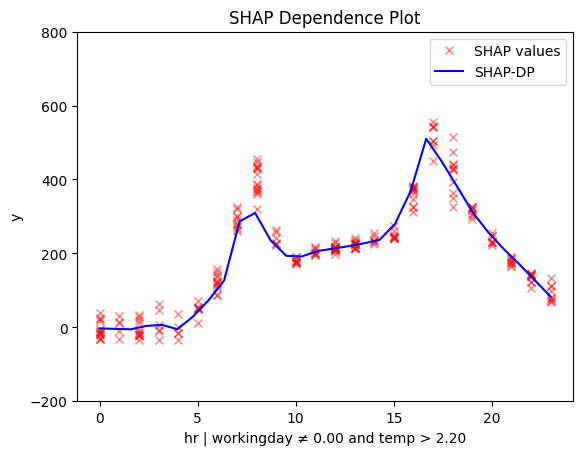

In [24]:
for node_idx in [2, 3, 5, 6]:
    regional_shap_dp.plot(feature=3, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### Conclusion  

Regional methods reveal two distinct patterns: one for **working days** and another for **non-working days**.  

- On **non-working days**, the pattern shifts to a single peak around **13:00**, likely driven by sightseeing and leisure.  
- On **working days**, the effect mirrors the global trend, with peaks around **8:00 and 17:00**, likely due to commuting.  

Diving deeper we observe that `temperature` interacts with `hour` forming these patterns: 

- On **non-working days** peaks between **12:00 and 14:00** become more pronounced in warmer conditions. Makes sense, right? If you're going sightseeing, you probably prefer to do it when the weather is nice.
- Similarly PDP and ShapDP show that on **working days** the peaks at **8:00** and **17:00** are dampened in colder conditions, likely because fewer people choose to bike to work in bad weather.
